# DETECTION OF AUTISM IN TODDLERS USING MACHINE LEARNING

### IMPORTING REQUIRED LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import norm
import warnings
import time
warnings.filterwarnings("ignore")

In [2]:
dataset = pd.read_csv("Qchat_Full_Polish_Cleaned.csv")

In [3]:
dataset.head()

,child_ID,sex,age,group,asd_risk,sum_qchat,Q01,Q02,Q03,Q04,...,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25
0,288,1,24,1,1,37,2,2,1,0,...,1,4,1,4,4,0,0,0,0,3
1,FS/2510,2,23,1,1,37,2,1,0,4,...,0,4,0,1,0,2,0,0,0,0
2,220,1,18,1,1,45,2,3,4,2,...,2,3,2,2,0,0,0,0,0,0
3,FS/2762,1,20,1,1,52,4,2,0,4,...,3,1,0,2,0,2,0,2,1,2
4,238,2,19,1,1,39,1,2,1,1,...,3,4,2,2,1,0,1,3,0,2


In [4]:
# drops the redundant column in the dataset
dataset = dataset.drop("child_ID", axis=1)

### LABEL ENCODER

In [5]:
encoder = LabelEncoder()

In [6]:
# This code encodes the features which are not numerical, for the machine learning model.
dataset["sex"] = encoder.fit_transform(dataset["sex"])
dataset["group"] = encoder.fit_transform(dataset["group"])
dataset["asd_risk"] = encoder.fit_transform(dataset["asd_risk"])

### FEATURE SELECTION

In [7]:
forest = RandomForestClassifier()

In [8]:
# separates the dependent and the independent variables
X = dataset.drop("asd_risk", axis = 1) #independent columns
y = dataset["asd_risk"] #target

In [9]:
forest.fit(X, y)

RandomForestClassifier()

In [10]:
importances = forest.feature_importances_

In [11]:
indices = np.argsort(importances)[::-1]

In [12]:
# selecting the best 10 features
X_forest = X.iloc[:, indices[:15]]

In [13]:
# viewing the selected columns
X_forest.columns.tolist()

['group',
 'age',
 'sum_qchat',
 'Q10',
 'Q03',
 'Q13',
 'Q23',
 'Q09',
 'Q19',
 'Q18',
 'Q01',
 'Q15',
 'Q02',
 'Q05',
 'Q11']

In [14]:
# separates the dependent and the independent variables
X = X_forest # feature selected independent columns

# NEURAL NETWORK IMPLEMENTATION

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torchvision import transforms
from tqdm.auto import tqdm
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import torch.nn.functional as F

### CREATE A CUSTOM DATASET CLASS

In [16]:
class Custom_Dataset(Dataset):
    def __init__(self, X, y, transform = None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  

In [17]:
# Define normalization transform
transform = transforms.Compose(
    [
    transforms.ToTensor(),
]
)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## DATA  SPLITTING FOR NEURAL NETWORK AND STANDARDIZATION

In [19]:
# separates the dependent and the independent variables
X = X_forest.values # feature selected independent columns
y = y.values

In [20]:
# splits the data into train sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=46)

In [21]:
# splits the data into test and validation sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=46)

In [22]:
# scaling the faetures
scaler = StandardScaler()

In [23]:
X_train = scaler.fit_transform(X_train)

In [24]:
X_test = scaler.transform(X_test)

In [25]:
X_val = scaler.transform(X_val)

#### CONVERT TO PYTORCH TENSORS

In [26]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

#### DATASET

In [27]:
train_dataset = Custom_Dataset(X_train, y_train, transform=transform)

In [28]:
test_dataset = Custom_Dataset(X_test, y_test, transform=transform)

In [29]:
val_dataset = Custom_Dataset(X_val, y_val, transform=transform)

#### DATALOADER

In [30]:
train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True
                         )

In [31]:
test_loader = DataLoader(test_dataset,
                        batch_size=32,
                        shuffle=False
                        )

In [32]:
val_loader = DataLoader(val_dataset,
                        batch_size=32,
                        shuffle=True
                        )

### BUILDING THE MLP ARCHITECTURE

In [33]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, output_dim, final_activation):
        super(MultiLayerPerceptron, self). __init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.final_activation = final_activation
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        if self.final_activation == "sigmoid":
            x = torch.sigmoid(self.fc3(x))
        else:
            x = self.fc3(x) # regression linear output
        return x

In [34]:
model = MultiLayerPerceptron(input_dim=X_train.shape[1], output_dim=1, final_activation="sigmoid")

#### TRAINING AND VALIDATION

In [35]:
train_accuracies = []
val_accuracies = []

In [36]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model.train()
    correct_train = 0
    total_train = 0
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            inputs = inputs.to(device, dtype = torch.float32)
            targets = targets.to(device, dtype = torch.float32)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            loss.backward()
            optimizer.step()
            
            # accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()
            
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # VALIDATION PHASE
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device, dtype = torch.float32)
                targets = targets.to(device, dtype = torch.float32)
                outputs = model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                
                _, predicted = torch.max(outputs, 1)
                total_val += targets.size(0)
                correct_val += (predicted == targets).sum().item()
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy) 
        print(f"Epoch {epoch+1} / {num_epochs}, Loss: {loss.item()}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")        


In [37]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### TESTING

In [38]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    predictions_list = []
    labels_list = []

    with torch.no_grad():
        predictions = model(X_test)
        
        if model.final_activation == "sigmoid":
            predictions = torch.round(predictions)
            correct = (predictions == y_test.view(-1, 1)).float().sum()
            accuracy = correct / y_test.shape[0]
            print(f"Accuracy: {accuracy.item() * 100:.2f}%")
        else:
            mse = F.mse_loss(predictions, y_test.view(-1, 1))
            print(f"MSE: {mse.item():.4f}")

        # Append predicted and actual labels to the lists
        predictions_list.extend(predictions.cpu().numpy())
        labels_list.extend(y_test.cpu().numpy())

    return predictions_list, labels_list

#### TRAINING VALIDATION AND TESTING

In [39]:
train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 1 / 20, Loss: 0.37111443281173706, Train Accuracy: 93.60%, Val Accuracy: 93.10%
Epoch 2 / 20, Loss: 0.5410284996032715, Train Accuracy: 93.60%, Val Accuracy: 93.10%
Epoch 3 / 20, Loss: 0.07038357853889465, Train Accuracy: 93.60%, Val Accuracy: 93.10%
Epoch 4 / 20, Loss: 0.08822935074567795, Train Accuracy: 93.60%, Val Accuracy: 93.10%
Epoch 5 / 20, Loss: 0.5360771417617798, Train Accuracy: 93.60%, Val Accuracy: 93.10%
Epoch 6 / 20, Loss: 0.21335521340370178, Train Accuracy: 93.60%, Val Accuracy: 93.10%
Epoch 7 / 20, Loss: 0.4674387276172638, Train Accuracy: 93.60%, Val Accuracy: 93.10%
Epoch 8 / 20, Loss: 0.3714975118637085, Train Accuracy: 93.60%, Val Accuracy: 93.10%
Epoch 9 / 20, Loss: 0.19465602934360504, Train Accuracy: 93.60%, Val Accuracy: 93.10%
Epoch 10 / 20, Loss: 0.06786156445741653, Train Accuracy: 93.60%, Val Accuracy: 93.10%
Epoch 11 / 20, Loss: 0.06614523380994797, Train Accuracy: 93.60%, Val Accuracy: 93.10%
Epoch 12 / 20, Loss: 0.5830737948417664, Train Accuracy:

In [40]:
predictions, labels = evaluate_model(model, X_test, y_test)

Accuracy: 93.63%


#### VISUALIZATION

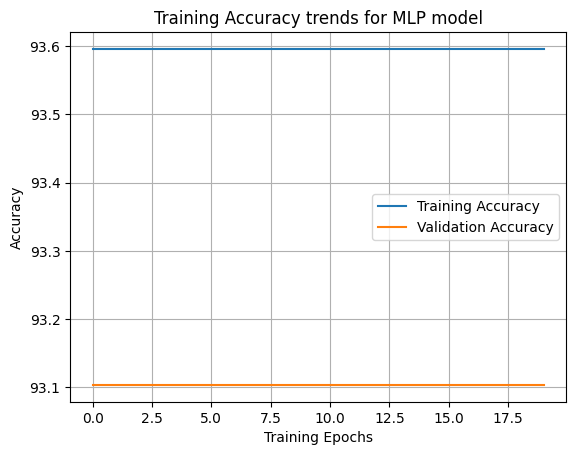

In [41]:
# plot accuracy progress
plt.title("Training Accuracy trends for MLP model")
plt.plot(train_accuracies, label = "Training Accuracy")
plt.plot(val_accuracies, label = "Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid(True)
plt.show()

### CLASSIFICATION REPORT

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [43]:
# these are gotten from the sklearn library
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions, average = "weighted")
recall = recall_score(labels, predictions, average = "weighted")
f1 = f1_score(labels, predictions, average = "weighted")

In [44]:
report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97       190
         1.0       0.60      0.21      0.32        14

    accuracy                           0.94       204
   macro avg       0.77      0.60      0.64       204
weighted avg       0.92      0.94      0.92       204

